[3:46:02.999212435] [7076]  INFO Camera camera_manager.cpp:297 libcamera v0.0.5+83-bde9b04f
[3:46:03.028394773] [8635]  WARN RPI vc4.cpp:383 Mismatch between Unicam and CamHelper for embedded data usage!
[3:46:03.029279909] [8635]  INFO RPI vc4.cpp:437 Registered camera /base/soc/i2c0mux/i2c@1/imx219@10 to Unicam device /dev/media0 and ISP device /dev/media2
[3:46:03.029336223] [8635]  INFO RPI pipeline_base.cpp:1101 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[3:46:03.041102068] [7076]  INFO Camera camera.cpp:1033 configuring streams: (0) 1280x720-XBGR8888 (1) 1920x1080-SBGGR10_CSI2P
[3:46:03.041722597] [8635]  INFO RPI vc4.cpp:565 Sensor: /base/soc/i2c0mux/i2c@1/imx219@10 - Selected sensor format: 1920x1080-SBGGR10_1X10 - Selected unicam format: 1920x1080-pBAA


dbMeter VERSION = 0x31
Unique ID: 0xb571729f 
 55  46  42  42  43  41  40  40  39  39  40  40  41  40  64  68  62  53  47  56  78 40.0
 75 39.0
 62 38.0
 50 37.0
 44 36.0
 41 35.0
 40 34.0
 40 33.0
 41 32.0
 42 31.0
 42 30.0
 42 29.0
 41 28.0
 40 27.0
 39 26.0
 40 25.0
 39 24.0
 39 23.0
 40 22.0
 41 21.0
 41 20.0
 41 19.0
 40 18.0
 39 17.0
 39 16.0
 39 15.0
 39 14.0
 40 13.0
 40 12.0
 39 11.0
 40 10.0
 39 9.0
 39 8.0
 39 7.0
 39 6.0
 39 5.0
 39 4.0
 39 3.0
 39 2.0
 39 1.0
 39 0.0
 40 exiting thread
20exiting function
 is trigger frame


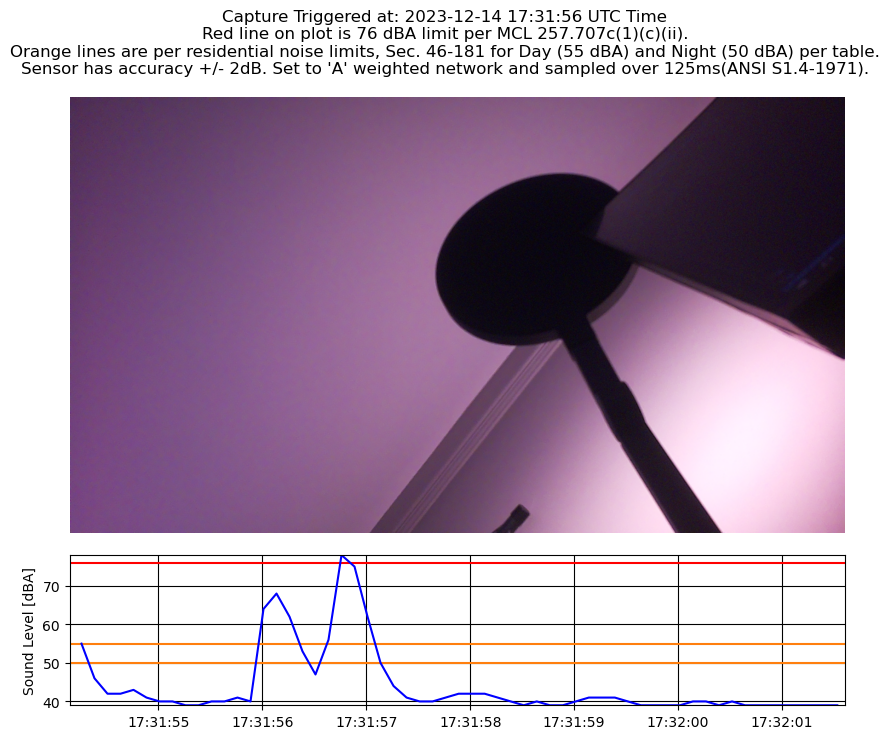

In [16]:
import sys
import smbus
import time
import atexit
import threading
from dbm import DBMeter
from picamera2 import Picamera2
from picamera2.encoders import H264Encoder, Encoder
from picamera2.outputs import CircularOutput
import concurrent.futures
from buffered_output import BufferedOutput
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
import numpy as np
import cv2
from matplotlib import animation

###############################################
# Camera setup.
picam2 = Picamera2()
fps = 24
dur = 10
micro = int((1 / fps) * 1000000)
vconfig = picam2.create_video_configuration()
vconfig['controls']['FrameDurationLimits'] = (micro, micro)
#vconfig['main']['size']=(1920,1080)
encoder = Encoder()
picam2.configure(vconfig)
interval = 0.125
##############
video_file_increment = 0;

from matplotlib import pyplot as plt
import cv2


def cleanup():
    picam2.stop_()
    picam2.close()

def startLoop():
    threading.Timer(interval,startLoop).start()
    a.capture()

def produceBaseFigure(trigger_time_string,plot_lims,sz):
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8),gridspec_kw={'height_ratios':[3,1],'hspace':0.05,'wspace':0.05})
    ax1.axis('off')
    img = ax1.imshow(np.zeros((sz[1],sz[0],4),np.uint8))
    fig.set_dpi(100)
    fig.suptitle("Capture Triggered at: " + trigger_time_string + " UTC Time\n" +
                 "Red line on plot is 76 dBA limit per MCL 257.707c(1)(c)(ii).\n" + 
                 "Orange lines are per residential noise limits, Sec. 46-181 for Day (55 dBA) and Night (50 dBA) per table.\n" +
                 "Sensor has accuracy +/- 2dB. Set to 'A' weighted network and sampled over 125ms(ANSI S1.4-1971).")
    ax2.grid(b=True, which='major', color='k', linestyle='-')
    ax2.axhline(y=76,color='r')
    ax2.axhline(y=55,color='tab:orange')
    ax2.axhline(y=50,color='tab:orange')
    ax2.set_ylabel('Sound Level [dBA]')
    ax2.set_xlim(plot_lims[0], plot_lims[1])
    ax2.set_ylim(plot_lims[2], plot_lims[3])
    db_line, = ax2.plot([],[], color="b")
    return fig, img, db_line
    
def animate(i,img, db_line,arr,video_frames,timestamp_deque,sz):
    img.set_array(np.reshape(np.frombuffer(video_frames[i], dtype=np.uint8),(sz[1],sz[0],4)))
    #find latest timestamp
    x_data =[]
    y_data =[]
    ts = timestamp_deque[i]
    k = 0; 
    while arr[k,0] < ts: 
        x_data.append(arr[k,0])
        y_data.append(arr[k,1])
        k=k+1
    db_line.set_data(x_data,y_data)
    return [db_line, img]

def generateVideoViaFunc(data_buffer,video_frames,timestamp_deque,vconfig):
    sz = vconfig['main']['size']
    # store generated images
    frames = [] 
    # pull the data in as a np array
    arr = np.asarray(data_buffer)
    db_max = arr.max(axis=0)[1]
    db_min = arr.min(axis=0)[1]
    plot_lims = [timestamp_deque[0],timestamp_deque[-1],db_min,db_max]
    trigger_data_frame = 0
    for i in range(len(data_buffer)):
        if data_buffer[i][1] > 70:
            trigger_data_frame = i
            print(i, end=" ")
            print("is trigger frame")
            break
            
    # set the title
    fig, img, db_line = produceBaseFigure(arr[trigger_data_frame,0].strftime("%Y-%m-%d %H:%M:%S"),plot_lims,sz)      
    time.sleep(0.05)            
    ani = animation.FuncAnimation(fig, animate, frames=len(video_frames), fargs=(img, db_line,arr,video_frames,timestamp_deque,sz), interval=41.6, blit=True)
    writergif = animation.PillowWriter(fps=24)
    ani.save(arr[trigger_data_frame,0].strftime("%Y_%m_%d_%H_%M_%S") + ".gif",writer=writergif)


if (__name__ == "__main__"):
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        atexit.register(cleanup)
        hold_fifo = 0
        file_name = str(video_file_increment).zfill(6)
        video_file_name = file_name+'.h264'
        output = BufferedOutput(buffersize=int(fps * (dur + 0.2)), outputtofile=False)
        picam2.start_recording(encoder, output)
        a = DBMeter("sound_meter_thread")
        a.set_queue_duration(10)
        a.start()
        a.join()
        hold_fifo = a.fifo
        print('exiting thread')
        output.stop()
        picam2.stop_recording()
        picam2.stop_()
        picam2.close()
        executor.submit(generateVideoViaFunc,hold_fifo,output.getFrames(),output.getTimestamps(),vconfig)
        #generateVideoViaFunc(hold_fifo,output.getFrames(),output.getTimestamps(),vconfig)
        print("exiting function")
    

In [ ]:
import numpy as np
test_arr = np.asarray(hold_fifo)
print(np.shape(test_arr))
print(test_arr)
#plt.setp(labels, rotation=90)
plt.plot(test_arr[:,0],test_arr[:,1])
plt.grid(b='on')
plt.xticks(rotation=45)
plt.title

In [ ]:
d_out = output.getFrames()
a = d_out.popleft()
sys.getsizeof(a)
# convert to numpy array 
image = np.asarray(bytearray(a)) 
sz=vconfig['main']['size']
image = np.reshape(image, (sz[1],sz[0],4))
#image = image[:,:,:3]
#image = cv2.imdecode(image, cv2.IMREAD_COLOR) 
#imageRGB = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
# display image 
plt.imshow(image)
#plt.pcolormesh(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
type(memoryview(output.getFrames()[1][0]))

In [ ]:
generateVideo(hold_fifo,output.getFrames(),output.getTimestamps(),vconfig)